In [1]:
%load_ext autoreload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys,os, pathlib
current = pathlib.Path(os.getcwd())
base = current.parent.parent
catenc = base.joinpath('categorical-encoding')
sys.path.append(str(catenc))

# Binary classification problem



In [3]:
rs_split = 8379
rs_enc = 1179
rs_rf = 5991
n_samples = 10000

In [4]:
from sklearn.datasets import make_classification
X_h, y_h = make_classification(n_samples = n_samples, n_features=10, n_informative=5, n_redundant=0, 
                               class_sep = 0.01, random_state=2834)

In [5]:
#Now convert the last column to the categorical
from sklearn.preprocessing import KBinsDiscretizer
disczr1 = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
cat_column1 = disczr1.fit_transform(X_h[:,-1].reshape(-1, 1)) * 193 % 20 #We want to break the monotonicity
disczr2 = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='uniform')
cat_column2 = disczr2.fit_transform(X_h[:,-2].reshape(-1, 1)) * 173 % 20 #We want to break the monotonicity

In [6]:
predictors = pd.DataFrame(X_h[:, 0:-2], columns=[f'col_{i}' for i in range(8)])
predictors['cat1'] = cat_column1
predictors['cat2'] = cat_column2
#predictors['cat1_orig'] = cat_column1
#predictors['cat2_orig'] = cat_column2
predictors.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,cat1,cat2
0,-0.487295,-0.147595,0.702684,-0.980724,-2.212259,-0.705400,1.487825,0.482706,16.0,18.0
1,0.639721,-1.635640,0.643382,0.953232,-0.178569,0.332062,2.076369,-0.756664,16.0,11.0
2,-0.894759,1.810931,1.427439,-0.638438,2.661236,-0.263417,1.359360,-0.759298,16.0,10.0


In [7]:
y_h[y_h<0] = 0

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=rs_split)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
model = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=3, min_samples_leaf=1,
                               random_state=rs_rf, n_jobs=-1) 
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:,1]

print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, preds.round()))
print('AUC: ', roc_auc_score(y_test, preds))

Train accuracy:  0.68975
Test accuracy:  0.6735
AUC:  0.7250086016859303


In [10]:
model.feature_importances_

array([0.00766255, 0.12502227, 0.20512611, 0.18482931, 0.01124271,
       0.4187756 , 0.00490739, 0.0112219 , 0.        , 0.03121215])

OK, Now we will try to use the probabilistic target encoder


## Cross-validation

We really should use cross-validation to avoid overfitting

### Cross-validation of the target encoding model

First we will train a model using target encoding

In [31]:
%%time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
import optuna
from optuna.distributions import *

loo = LeaveOneOutEncoder(cols=['cat1', 'cat2'], sigma=0.05, random_state=2834)
rf = RandomForestClassifier(n_estimators=400, random_state=2834, n_jobs=-1) 
pipe = Pipeline(steps=[('loo',loo), ('rf',rf)])

param_distribution = {
    'loo__sigma': LogUniformDistribution(1E-5, 1E-1),
    'rf__max_depth': IntUniformDistribution(5,40),
    'rf__max_features' : IntUniformDistribution(1,10),
    'rf__min_samples_leaf': IntUniformDistribution(1,3)
}

X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

loo_search = optuna.integration.OptunaSearchCV(pipe, param_distribution, 
                cv=5, n_jobs=-1, random_state=514, n_trials=None, timeout= 5*60, scoring='accuracy')

loo_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % loo_search.best_score_)
print(loo_search.best_params_)


[I 2020-05-17 21:30:39,105] Finished trial#1 with value: 0.5625 with parameters: {'loo__sigma': 0.00013358802142716134, 'rf__max_depth': 27, 'rf__max_features': 7, 'rf__min_samples_leaf': 3}. Best is trial#1 with value: 0.5625.
[I 2020-05-17 21:30:39,554] Finished trial#4 with value: 0.5945 with parameters: {'loo__sigma': 1.1934830195163982e-05, 'rf__max_depth': 14, 'rf__max_features': 5, 'rf__min_samples_leaf': 2}. Best is trial#4 with value: 0.5945.
[I 2020-05-17 21:30:42,241] Finished trial#7 with value: 0.7358750000000001 with parameters: {'loo__sigma': 0.0007755343629811461, 'rf__max_depth': 17, 'rf__max_features': 3, 'rf__min_samples_leaf': 3}. Best is trial#7 with value: 0.7358750000000001.
[I 2020-05-17 21:30:43,633] Finished trial#0 with value: 0.663125 with parameters: {'loo__sigma': 0.00022028426661920117, 'rf__max_depth': 40, 'rf__max_features': 3, 'rf__min_samples_leaf': 2}. Best is trial#7 with value: 0.7358750000000001.
[I 2020-05-17 21:30:44,400] Finished trial#2 with v

[I 2020-05-17 21:34:31,779] Finished trial#35 with value: 0.79775 with parameters: {'loo__sigma': 0.03027019818799291, 'rf__max_depth': 39, 'rf__max_features': 4, 'rf__min_samples_leaf': 1}. Best is trial#33 with value: 0.820375.
[I 2020-05-17 21:34:32,350] Finished trial#34 with value: 0.798 with parameters: {'loo__sigma': 0.028304162672556598, 'rf__max_depth': 37, 'rf__max_features': 4, 'rf__min_samples_leaf': 1}. Best is trial#33 with value: 0.820375.
[I 2020-05-17 21:34:38,680] Finished trial#36 with value: 0.8167500000000001 with parameters: {'loo__sigma': 0.0045936944383394495, 'rf__max_depth': 40, 'rf__max_features': 4, 'rf__min_samples_leaf': 3}. Best is trial#33 with value: 0.820375.
[I 2020-05-17 21:34:40,028] Finished trial#37 with value: 0.8166249999999999 with parameters: {'loo__sigma': 0.004823173862804704, 'rf__max_depth': 40, 'rf__max_features': 4, 'rf__min_samples_leaf': 3}. Best is trial#33 with value: 0.820375.


Best parameter (CV score=0.820):
{'loo__sigma': 0.004047611774928666, 'rf__max_depth': 39, 'rf__max_features': 4, 'rf__min_samples_leaf': 1}
Wall time: 5min 47s


In [32]:
test_predict = loo_search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

Test accuracy:  0.818


### Cross-validation of the probabilistic encoder

First we create a class that makes it easier for us to run sklearn cross validation

In [13]:
from category_encoders.posterior_imputation_bc import PosteriorImputationEncoderBC  
from category_encoders.pte_utils import EncoderWrapper

In [14]:
%%time
from sklearn.model_selection import cross_val_score
import optuna
from optuna.distributions import *


pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], n_draws=5, random_state=2834, prior_samples_ratio=0)
model = RandomForestClassifier(n_estimators=400, max_depth=30, max_features=1, 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_distribution = {
    'encoder__prior_samples_ratio': LogUniformDistribution(1E-9, 1E-1),
    'encoder__n_draws': IntUniformDistribution(1,40),
    'encoder__leave_one_out': CategoricalDistribution([False, True]),
    'classifier__max_depth': IntUniformDistribution(5,40),
    'classifier__max_features' : IntUniformDistribution(1,10),
    'classifier__min_samples_leaf': IntUniformDistribution(1,10)
}


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

search = optuna.integration.OptunaSearchCV(wrapper_model, param_distribution, 
            cv=5, n_jobs=-1, random_state=514, n_trials=None, timeout= 90*60, scoring='accuracy')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

[I 2020-05-17 10:57:57,813] Finished trial#10 with value: 0.756625 with parameters: {'encoder__prior_samples_ratio': 8.404266964662115e-07, 'encoder__n_draws': 15, 'encoder__leave_one_out': False, 'classifier__max_depth': 14, 'classifier__max_features': 1, 'classifier__min_samples_leaf': 9}. Best is trial#10 with value: 0.756625.
[I 2020-05-17 11:06:25,743] Finished trial#2 with value: 0.7826249999999999 with parameters: {'encoder__prior_samples_ratio': 0.08482114247808023, 'encoder__n_draws': 21, 'encoder__leave_one_out': False, 'classifier__max_depth': 28, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 8}. Best is trial#2 with value: 0.7826249999999999.
[I 2020-05-17 11:06:34,461] Finished trial#4 with value: 0.7819999999999999 with parameters: {'encoder__prior_samples_ratio': 1.4320384297743452e-08, 'encoder__n_draws': 20, 'encoder__leave_one_out': False, 'classifier__max_depth': 23, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 2}. Best is trial#2 w

[I 2020-05-17 11:39:47,892] Finished trial#25 with value: 0.793875 with parameters: {'encoder__prior_samples_ratio': 1.564487878296161e-05, 'encoder__n_draws': 9, 'encoder__leave_one_out': True, 'classifier__max_depth': 19, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 1}. Best is trial#25 with value: 0.793875.
[I 2020-05-17 11:40:58,194] Finished trial#9 with value: 0.7827500000000001 with parameters: {'encoder__prior_samples_ratio': 0.0008192105388735917, 'encoder__n_draws': 39, 'encoder__leave_one_out': True, 'classifier__max_depth': 25, 'classifier__max_features': 2, 'classifier__min_samples_leaf': 6}. Best is trial#25 with value: 0.793875.
[I 2020-05-17 11:41:19,840] Finished trial#33 with value: 0.7942500000000001 with parameters: {'encoder__prior_samples_ratio': 1.173750715694586e-05, 'encoder__n_draws': 2, 'encoder__leave_one_out': True, 'classifier__max_depth': 40, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 3}. Best is trial#33 with value: 

[I 2020-05-17 12:05:10,020] Finished trial#22 with value: 0.7893749999999999 with parameters: {'encoder__prior_samples_ratio': 2.5907360076560736e-05, 'encoder__n_draws': 40, 'encoder__leave_one_out': True, 'classifier__max_depth': 19, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 7}. Best is trial#42 with value: 0.7957500000000001.
[I 2020-05-17 12:06:33,887] Finished trial#53 with value: 0.7926249999999999 with parameters: {'encoder__prior_samples_ratio': 0.00021827271298742058, 'encoder__n_draws': 2, 'encoder__leave_one_out': True, 'classifier__max_depth': 36, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 3}. Best is trial#42 with value: 0.7957500000000001.
[I 2020-05-17 12:06:37,405] Finished trial#47 with value: 0.7841250000000001 with parameters: {'encoder__prior_samples_ratio': 2.5781911037009394e-06, 'encoder__n_draws': 13, 'encoder__leave_one_out': True, 'classifier__max_depth': 36, 'classifier__max_features': 7, 'classifier__min_samples_leaf'

[I 2020-05-17 12:18:13,641] Finished trial#73 with value: 0.7928750000000001 with parameters: {'encoder__prior_samples_ratio': 4.3410780355573535e-05, 'encoder__n_draws': 7, 'encoder__leave_one_out': False, 'classifier__max_depth': 34, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 2}. Best is trial#42 with value: 0.7957500000000001.
[I 2020-05-17 12:18:30,694] Finished trial#58 with value: 0.792125 with parameters: {'encoder__prior_samples_ratio': 0.00035539874002480325, 'encoder__n_draws': 3, 'encoder__leave_one_out': True, 'classifier__max_depth': 21, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 1}. Best is trial#42 with value: 0.7957500000000001.
[I 2020-05-17 12:19:27,073] Finished trial#74 with value: 0.787 with parameters: {'encoder__prior_samples_ratio': 8.20604296902793e-06, 'encoder__n_draws': 8, 'encoder__leave_one_out': False, 'classifier__max_depth': 34, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 2}. Best is trial#42 wi

Best parameter (CV score=0.799):
{'encoder__prior_samples_ratio': 8.392614866847138e-06, 'encoder__n_draws': 5, 'encoder__leave_one_out': False, 'classifier__max_depth': 17, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 2}
Wall time: 1h 35min 6s


In [15]:
test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

Test accuracy:  0.797


### Study how hyperparameters influence the model performance

#### Leave one out or not?

In [16]:
from sklearn.model_selection import GridSearchCV
pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                                   n_draws=search.best_params_['encoder__n_draws'], 
                                   random_state=2834, 
                                   prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                                   leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                               max_depth=search.best_params_['classifier__max_depth'], 
                               max_features=search.best_params_['classifier__max_features'], 
                               min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)


search1 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__leave_one_out' : [False, True]})

search1.fit(X_train, y_train)
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

[0.795  0.7945]
[0.00368697 0.01074128]


In [17]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range = range(2, 20)
search2 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__n_draws' : param_range})

search2.fit(X_train, y_train)
results2 = search2.cv_results_['mean_test_score']    
results_std2 = search2.cv_results_['std_test_score']
    
print(results1)
plt.figure(1, figsize=(15, 10))
plt.plot(list(param_range), results, 'b-o')
plt.fill_between(list(param_range), results - search2.cv_results_['std_test_score'],
                 results + search2.cv_results_['std_test_score'], color='lightgrey')
plt.show();

NameError: name 'results1' is not defined

In [20]:
search2.cv_results_

{'mean_fit_time': array([ 2.35578599,  3.32319574,  4.17339096,  4.61597075,  5.36120629,
         6.15056906,  6.97721138,  7.79360218,  8.68319569,  9.56141443,
        10.51798115, 11.44299402, 12.42344346, 13.40461235, 14.43117862,
        15.52882628, 16.59537649, 17.5909946 ]),
 'std_fit_time': array([0.02910035, 0.05563373, 0.04787264, 0.05725923, 0.02222918,
        0.04965407, 0.07951735, 0.04818342, 0.04900018, 0.04921231,
        0.12135459, 0.09288278, 0.09062887, 0.07774549, 0.13364666,
        0.16641947, 0.10449466, 0.137611  ]),
 'mean_score_time': array([0.23412576, 0.3166811 , 0.31851001, 0.31947703, 0.32105341,
        0.36439505, 0.42511554, 0.42765322, 0.42903533, 0.43128147,
        0.41189198, 0.43403826, 0.41543798, 0.43754692, 0.43858242,
        0.44118752, 0.46174364, 0.42274289]),
 'std_score_time': array([0.04093703, 0.00080299, 0.00055568, 0.00089621, 0.00106992,
        0.04870156, 0.00074221, 0.00140349, 0.00116351, 0.00109357,
        0.03945598, 0.0008

ValueError: x and y must have same first dimension, but have shapes (38,) and (18,)

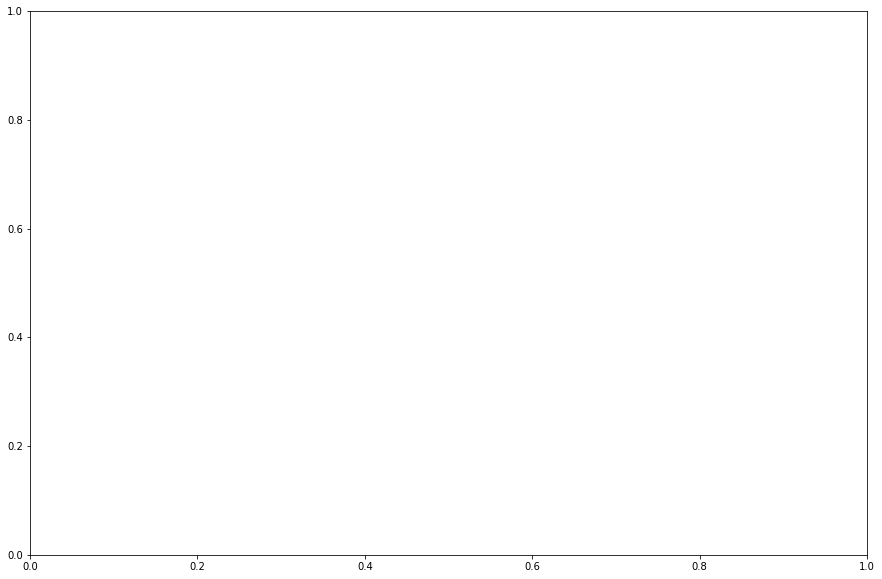

In [19]:
param_range = range(2, 40)
results = search2.cv_results_['mean_test_score']   
plt.figure(1, figsize=(15, 10))
plt.plot(list(param_range), results, 'b-o')
plt.fill_between(list(param_range), results - search2.cv_results_['std_test_score'],
                 results + search2.cv_results_['std_test_score'], color='lightgrey')
plt.show();

[0.79425  0.8025   0.795625 0.799625 0.795375 0.795125 0.796375 0.793875
 0.793125 0.79325  0.79425  0.794875 0.7915   0.79475  0.79125  0.792125
 0.793625 0.792875]


ValueError: x and y must have same first dimension, but have shapes (9,) and (18,)

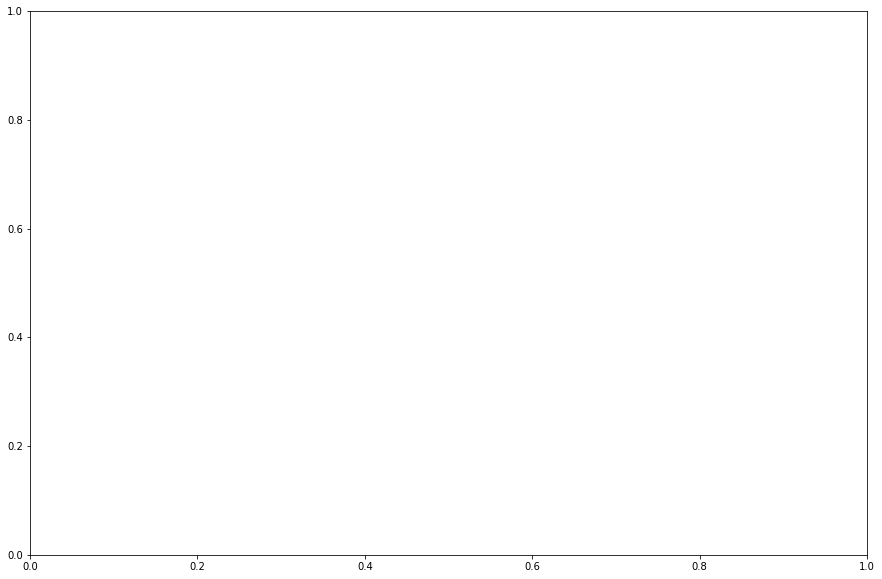

In [21]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range =  range(-10, -1)
search3 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__prior_samples_ratio' : [10**i for i in param_range]})

search3.fit(X_train, y_train)
    
results3 = search2.cv_results_['mean_test_score']    
results_std3 = search2.cv_results_['std_test_score']
    
print(results)
plt.figure(1, figsize=(15, 10))
plt.plot(list(param_range), results, 'b-o')
plt.fill_between(list(param_range), results - search3.cv_results_['std_test_score'],
                 results + search3.cv_results_['std_test_score'], color='lightgrey')
plt.show();

In [22]:
search3.cv_results_

{'mean_fit_time': array([4.50678844, 4.47201796, 4.52320228, 4.63338213, 4.6687788 ,
        4.67578816, 4.66562748, 4.65751662, 4.60330057]),
 'std_fit_time': array([0.09866571, 0.02971118, 0.06583173, 0.07443556, 0.03798292,
        0.05823376, 0.08388171, 0.1112733 , 0.01915959]),
 'mean_score_time': array([0.3193449 , 0.31795311, 0.31917744, 0.38133879, 0.4013001 ,
        0.34045691, 0.31973209, 0.319561  , 0.36084905]),
 'std_score_time': array([0.00128665, 0.00080121, 0.00117117, 0.08271606, 0.04063737,
        0.03983765, 0.00083768, 0.00076381, 0.04905848]),
 'param_encoder__prior_samples_ratio': masked_array(data=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                    0.001, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'encoder__prior_samples_ratio': 1e-10},
  {'encoder__prior_samples_ratio': 1e-09},
  {'encoder__prior_samples_ratio

In [30]:
import pickle
with open('classification_search1.pickle', 'wb') as pickle_file:
    pickle.dump(search1.cv_results_, pickle_file)
with open('classification_search2.pickle', 'wb') as pickle_file:
    pickle.dump(search2.cv_results_, pickle_file)
with open('classification_search3.pickle', 'wb') as pickle_file:
    pickle.dump(search3.cv_results_, pickle_file)

In [40]:
loo_search.best_estimator_['rf'].feature_importances_

array([0.0549712 , 0.14388096, 0.12816001, 0.1448246 , 0.05131392,
       0.2015114 , 0.05158135, 0.0508333 , 0.06575204, 0.10717121])

In [42]:
search.best_estimator_.classifier.feature_importances_

array([0.0577605 , 0.17682848, 0.14722262, 0.16281221, 0.05303048,
       0.22826332, 0.05332863, 0.05230191, 0.01431999, 0.05413187])

In [50]:
with open('class_loo_import.pickle', 'wb') as f:
    pickle.dump(loo_search.best_estimator_['rf'].feature_importances_, f)
with open('class_sam_import.pickle', 'wb') as f:
    pickle.dump(search.best_estimator_.classifier.feature_importances_, f)